In [49]:
#%reset -f -s
%matplotlib inline
'''------------------------------------------------------------------
MA-eR-PINN: eRange Prediction using Physics-Informed Neural Networks
---------------------------------------------------------------------
Version: V2.0      Modified: 12.01.2025        William Siegle
---------------------------------------------------------------------
PTRAIN - Standard Pipeline Framework for Training the PINN
+ OPTUNA - Hyperparameter Optimization using Optuna
------------------------------------------------------------------''';

In [34]:
# MA-eR-PINN: CONFIGURATION FILE -------------------------------------------------
from pathlib import Path
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "GPU_SELECT":       0, # {0,1,2,3, None: CPU only}
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_pinn_2"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "SEED"  :           25,
    "PLOT_ACTIVE":      True,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.19, 0.01], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "MIN_SEQ_LENGTH":   600, # minimum sequence length in s to be included in DataSets
    "SCALERS":          {'feature_scaler': 'MaxAbsScaler()','target_scaler': 'MinMaxScaler(feature_range=(0, 1))','prior_scaler': 'MinMaxScaler(feature_range=(0, 1))'},

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ['accelpdlposn_cval','actdrvtrnpwrprc_cval','actualdcvoltage_pti1','actualspeed_pti1','actualtorque_pti1',
                        'airtempinsd_cval_hvac','airtempinsd_rq','airtempoutsd_cval_cpc','altitude_cval_ippc','brc_stat_brc1','brktempra_cval',
                        'bs_brk_cval','currpwr_contendrnbrkresist_cval','elcomp_pwrcons_cval','epto_pwr_cval','hv_bat_dc_momvolt_cval_bms1',
                        'hv_batavcelltemp_cval_bms1','hv_batcurr_cval_bms1','hv_batisores_cval_e2e','hv_batmaxchrgpwrlim_cval_1',
                        'hv_batmaxdischrgpwrlim_cval_1','hv_curr_cval_dcl1','hv_dclink_volt_cval_dcl1','hv_ptc_cabin1_pwr_cval','hv_pwr_cval_dcl1',
                        'lv_convpwr_cval_dcl1','maxrecuppwrprc_cval','maxtracpwrpct_cval','motortemperature_pti1','powerstagetemperature_pti1',
                        'rmsmotorcurrent_pti1','roadgrad_cval_pt','selgr_rq_pt','start_soc','txoiltemp_cval_tcm','vehspd_cval_cpc','vehweight_cval_pt'],                 
    "TARGETS":          ['hv_bat_soc_cval_bms1'],
    "PRIORS":           ['emot_soc_pred'],  

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      200,    # features in the hidden state h
    "NUM_LAYERS":       2,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.35,   # usually: [0.2 - 0.5]
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       10,
    "BATCH_SIZE":       64,         # [2, 4, 8, 16, 32, 64, 128, 256]
    "LEARNING_RATE":    1e-2,       # 0.001 lr
    "WEIGHT_DECAY":     1e-2,       # weight decay coefficient (default: 1e-2)
    "MOMENTUM_SGD":     0.0,        # (default: 0.0)
    "OPTIMIZER":        'adamw',    # ('adam', 'sgd', 'adamw')
    "WEIGHT_INIT_TYPE": 'normal',   # ('he', 'normal', 'default')
    "LRSCHEDULER":      "torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda _: 1.0)",  # constant LR for 1.0 as multiplicative factor
                        # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 3, factor = 0.5, min_lr = 1e-7)

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", # ['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']
    "LOSS_FN":          "F.mse_loss(output, target)", # ['F.mse_loss(output, target)', 'F.l1_loss(output, target)', 'F.smooth_l1_loss(output, target)', 'F.huber_loss(output, target)', 'F.mase_loss(output, target)']
    "P_LOSS_FACTOR":    0.1, # Physics loss factor
}

In [35]:
# OPTUNA: SEARCH SPACE ---------------------------------------------------
global search_space, search_space_NewData
search_space = {
    # MODEL: -----------------------------------------------------------------------
    'HIDDEN_SIZE': ('int', 50, 400, 50),
    'NUM_LAYERS': ('int', 1, 5, 1),
    'DROPOUT': ('float', 0.05, 0.5, 0.05),
    'WEIGHT_INIT_TYPE': ('categorical', ('he', 'normal', 'default')),
    #'BATCH_NORM_ON': ('categorical', (True, False))

    # TRAINING & OPTIMIZER: --------------------------------------------------------
    'OPTIMIZER': ('categorical', ('adam', 'sgd', 'adamw')),
    'NUM_EPOCHS': ('int', 5, 20, 1),
    'LEARNING_RATE': ('categorical', (1e-5, 5e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 3e-3, 5e-3, 8e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1)),
    'WEIGHT_DECAY': ('categorical', (0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2)),
    'MOMENTUM_SGD': ('float', 0.0, 0.9, 0.1),

    # LOSS: --------------------------------------------------------
    'CRITERION': ('categorical', ('nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()')),
    'P_LOSS_FACTOR': ('float', 0.0, 1.0, 0.05)
}

search_space_NewData = {
    # DATA PREPROCESSING: ---------------------------------------------------------
    "MIN_SEQ_LENGTH": ('int', 300, 3600, 300),
    'BATCH_SIZE': ('categorical', (4, 8, 16, 32, 64, 128)),
}

N_TRIALS = 50

___
SETUP: Locate devices & system folders

In [36]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
import sys, os
for key in CONFIG: globals()[key] = CONFIG[key]
print(ROOT)
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
sys.path.append(os.path.abspath(ROOT))

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
from src.__init__ import *
from src.utils.data_utils import *
from src.utils.preprocess_utils import *
from src.utils.eval_utils import *
from src.utils.Trainers import *
from src.models.lstm_models import *

# SETUP ENVIRONMENT ---------------------------------------------------------------------
DATA_PATH, IS_NOTEBOOK, DEVICE = setup_environment(CONFIG, ROOT, SEED, GPU_SELECT)

/home/sieglew/MA-eR-PINN
------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			test, .git, archive, project, data, src
  /mnt/nvme/datasets/sieglew:			TripSequences
------------------------------------------------------------
Running in notebook mode
CONFIG Dictionary:
---------------------------------------------------------------------------------------------------------------------------------
     Parameter         Value
--  ----------------  -------------------------------------------------------------------------
0   GPU_SELECT        0
1   ROOT              /home/sieglew/MA-eR-PINN
2   INPUT_LOCATION    TripSequences/trips_processed_pinn_2
3   OUTPUT_LOCATION   src/models/pth
4   SEED              25
5   PLOT_ACTIVE       True
6   TRAIN_VAL_TEST    [0.8, 0.19, 0.01]
7   MAX_FILES         1500
8   MIN_SEQ_LENGTH    600
9   SCALERS           {'feature_scaler': 'MaxAbsScaler()',
                       'target_scaler': 'MinMaxScaler(

___
DATA SELECTION & PREPROCESSING

In [37]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION)
files, trip_lengths, indices_by_length, sorted_trip_lengths, all_signals = prepare_data(input_folder, pth_folder, MAX_FILES, MIN_SEQ_LENGTH, ROOT)

------------------------------------------------------------
Total Files:	1500
Filtered Files:	1134
------------------------------------------------------------
               FileName  Length  Index
0      V12_T905.parquet   15862    570
1      V13_T420.parquet   15744    555
2      V13_T739.parquet   15593   1094
3      V13_T118.parquet   15221    708
4      V13_T941.parquet   14819     38
...                 ...     ...    ...
1129  V16_T1333.parquet     619    691
1130  V17_T3659.parquet     615    552
1131  V16_T2172.parquet     608   1023
1132   V13_T252.parquet     603   1064
1133    V12_T55.parquet     602    666

[1134 rows x 3 columns]


In [38]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
                "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped (from Features) in order for appropriate training:
columns_to_drop = ["signal_time",                       # works as index
                    "hirestotalvehdist_cval_icuc",      # starts from 0, obtained by speed integration
                    "latitude_cval_ippc",               # only GPS 
                    "longitude_cval_ippc",              # only GPS
                    "hv_batpwr_cval_bms1",              # directly related to target (soc_gradient)
                    "hv_batmomavldischrgen_cval_1",     # indirect target 1 in kWh
                    "hv_bat_soc_cval_bms1",              # indirect target 2 in %SoC
                    "soc_gradient",                     # actual target signal   
                    "emot_pwr_cval",                    # replaced as physical prior for PINN
                    "emot_pwr_pred",                    # actual physical prior for PINN
                    ]

# Ensure no element of "columns_to_drop" is included in "FEATURES"
assert not any(col in FEATURES for col in columns_to_drop), "Some columns to drop are still in FEATURES"

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

In [39]:
# FEATURE SELECTION  ----------------------------------------------------------------------------
INPUT_COLUMNS = FEATURES; TARGET_COLUMN = TARGETS; PRIOR_COLUMN = PRIORS
print(f"{'-'*60}\nInput Signals:\t{len(FEATURES)}\nTarget Signals:\t{len(TARGETS)}\nPhysical Prior Signals:\t{len(PRIORS)}\n{'-'*60}")

# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])
prior_scaler = eval(SCALERS['prior_scaler'])

------------------------------------------------------------
Input Signals:	37
Target Signals:	1
Physical Prior Signals:	1
------------------------------------------------------------


In [40]:
# DATA SET SPLITTING AND SORTING ----------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

# DATALOADER SETTINGS ------------------------------------------------------------------
dataloader_settings = {
    'batch_size': 1,                    # see *Note above
    'shuffle': True,                    # shuffle the batches before each epoch
    'collate_fn': collate_fn_PINN,      # include optional arguments
    'num_workers': 8,                   # number of workers
    'prefetch_factor': 4,               # number of samples loaded in advance by each worker
    'persistent_workers': True,         # whether the data loader workers are allowed to persist
    'pin_memory': False if DEVICE.type == 'cpu' else True}

# PREPARE TRAIN, VAL & TEST DATALOADERS  ------------------------------------------------------------
train_subset, train_dataset, train_dataset_batches, train_loader = prepare_dataloader_PINN(train_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, fit=True, drop_last=True)

val_subset, val_dataset, val_dataset_batches, val_loader = prepare_dataloader_PINN(val_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=True)

test_subset, test_dataset, test_dataset_batches, test_loader = prepare_dataloader_PINN(test_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=True)

# print dataset info
subset_files = print_dataset_sizes(train_dataset, val_dataset, test_dataset, train_subset, val_subset, test_subset, files)

 --> Warning: Removed the last 12 samples to ensure a balanced batch size
fitting Scalers: MaxAbsScaler, MinMaxScaler, MinMaxScaler
	50% of the fitting done...
Done. Create DataSets and DataLoaders...
	Number of batches created: 28
 --> Warning: Removed the last 23 samples to ensure a balanced batch size
	Number of batches created: 6
------------------------------------------------------------
Train size:  2894045		(Files: 896)
Val. size:   713667		(Files: 192)
Test size:   375582		(Files: 11) 
 ------------------------------------------------------------
	Removed 35 file from the dataset
------------------------------------------------------------
first 3 train files: ['V13_T420.parquet', 'V13_T739.parquet', 'V13_T118.parquet']


In [41]:
# Load dataloaders
#train_loader = torch.load('train_loader.pth')
#val_loader = torch.load('val_loader.pth')
#test_loader = torch.load('test_loader.pth')

In [42]:
if IS_NOTEBOOK and False: 
    check_batch_PINN(train_loader)
    visualize_padding(BATCH_SIZE, trip_lengths, sorted_trip_lengths, train_loader, val_loader, test_loader)

___
MODEL & TRAINING CONFIGURATIONS

In [43]:
# LSTM NETWORK -----------------------------------------------------------------------

class LSTM1_packed_old_version(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device=DEVICE):
        super(LSTM1_packed_old_version, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            self.input_size,            # The number of expected features in the input x
            self.hidden_size,           # The number of features in the hidden state h
            self.num_layers,            # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first=True,           # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            dropout=self.dropout,       # usually: [0.2 - 0.5], introduces a Dropout layer on the outputs of each LSTM layer except the last layer, (dropout probability). Default: 0
            device=device)

        # LAYERS -----------------------------------
        self.dropout_layer = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()

    def forward(self, packed_input, batch_size=None):
        packed_out, _ = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.relu(out)  # relu
        out = self.dropout_layer(out)  # dropout
        out = self.fc1(out)  # fully connected layer 1
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)  # relu
        out = self.fc2(out)  # fully connected layer 2
        return out

# Define the weight initialization function for LSTM
def initialize_weights_lstm(model, init_type):
    for name, param in model.named_parameters():
        if 'weight_ih' in name or 'weight_hh' in name:
            if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')  # HE INIT
            elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02) # NORMAL INIT
            elif init_type == 'default': continue # Skip custom initialization to use PyTorch's default initialization # DEFAULT INIT
        elif 'bias' in name and init_type != 'default': nn.init.constant_(param.data, 0)

___
TRAINING

___
OPTUNA: Hyperparameter Optimization

In [44]:
# OPTUNA: OBJECTIVE ---------------------------------------------------
def objective(trial):

    # OPTUNA: CREATE TRIAL OBJECTS ---------------------------------------------------
    optuna_params = {}
    for param, (suggest_type, *args) in search_space.items():
        if suggest_type == 'int': optuna_params[param.lower()] = trial.suggest_int(param, *args[:2], step=args[2])
        elif suggest_type == 'float': optuna_params[param.lower()] = trial.suggest_float(param, *args[:2], step=args[2])
        elif suggest_type == 'categorical': optuna_params[param.lower()] = trial.suggest_categorical(param, *args)
    
    # Update CONFIG with suggested hyperparameters
    for param in optuna_params.keys(): CONFIG[param.upper()] = optuna_params[param]
    for key in CONFIG: locals()[key] = CONFIG[key]
    # -----------------------------------------------------------------------------------

    # TRAINING_CODE: -----------------------------------------------------------------
    # INSTANTIATE MODEL AND APPLY WEIGHT INITIALIZATION --------------------
    model = LSTM1_packed_old_version(len(INPUT_COLUMNS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
    initialize_weights_lstm(model, WEIGHT_INIT_TYPE)
    
    if OPTIMIZER=='adam': optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER=='adamw': optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
    elif OPTIMIZER=='sgd': optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_SGD, weight_decay=WEIGHT_DECAY)

    scheduler = eval(LRSCHEDULER); criterion = eval(CRITERION)

    # LOSS FUNCTION ----------------------------------------------------------------   
    def loss_fn_PINN_3(output, target, prior):
        l_p = P_LOSS_FACTOR
        y_pred = output; y_true = target; y_phys = prior
        total_loss = F.mse_loss(y_true, (l_p * y_phys + (1 - l_p) * y_pred), reduction='mean')
        return total_loss

    # TRAIN -----------------------------------------------------------------
    TRAINER = PTrainer_PINN(
        model = model, 
        optimizer = optimizer,
        scheduler = scheduler, 
        loss_fn = loss_fn_PINN_3, 
        train_loader = train_loader,
        val_loader = val_loader,
        test_loader = test_loader,
        num_epochs = NUM_EPOCHS, 
        device = DEVICE, 
        is_notebook = IS_NOTEBOOK,
        use_mixed_precision = True)

    RESULTS = TRAINER.train_model()
    plot_training_performance(RESULTS)

    # RETURN latest val_loss ---------------------------------------------------------
    val_loss = RESULTS['val_losses'][-1]

    return val_loss

[I 2025-01-12 16:42:59,165] A new study created in memory with name: no-name-352b070b-016f-46dc-a8aa-7a0a6053f354


------------------------------------------------------------
Training Started.	Process ID: 1181158 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	28 / 28
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7f422fa30e00>
Optimizer:		AdamW
LR:			0.01
Weight Decay:		0.01
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/28 [00:00<?, ?batch/s]

/home/sieglew/.conda/envs/sieglew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

[I 2025-01-12 16:43:28,132] Trial 0 finished with value: 0.06731441182394822 and parameters: {'HIDDEN_SIZE': 50, 'NUM_LAYERS': 3, 'DROPOUT': 0.2, 'WEIGHT_INIT_TYPE': 'normal', 'OPTIMIZER': 'adamw', 'LEARNING_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'MOMENTUM_SGD': 0.8, 'CRITERION': 'nn.HuberLoss()', 'P_LOSS_FACTOR': 0.15000000000000002}. Best is trial 0 with value: 0.06731441182394822.


------------------------------------------------------------
Training Completed.	Execution Time: 00:00:29
------------------------------------------------------------

------------------------------------------------------------
Training Started.	Process ID: 1181158 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	28 / 28
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7f4270f64ae0>
Optimizer:		AdamW
LR:			0.01
Weight Decay:		0.01
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

[I 2025-01-12 16:43:55,418] Trial 1 finished with value: 0.03517916239798069 and parameters: {'HIDDEN_SIZE': 350, 'NUM_LAYERS': 3, 'DROPOUT': 0.35000000000000003, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'adamw', 'LEARNING_RATE': 0.01, 'WEIGHT_DECAY': 0.0, 'MOMENTUM_SGD': 0.2, 'CRITERION': 'nn.L1Loss()', 'P_LOSS_FACTOR': 1.0}. Best is trial 1 with value: 0.03517916239798069.


------------------------------------------------------------
Training Completed.	Execution Time: 00:00:27
------------------------------------------------------------

------------------------------------------------------------
Training Started.	Process ID: 1181158 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	28 / 28
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7f42ba634540>
Optimizer:		AdamW
LR:			0.01
Weight Decay:		0.01
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

[I 2025-01-12 16:44:22,253] Trial 2 finished with value: 0.04783391331632932 and parameters: {'HIDDEN_SIZE': 200, 'NUM_LAYERS': 1, 'DROPOUT': 0.2, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'adamw', 'LEARNING_RATE': 0.005, 'WEIGHT_DECAY': 1e-06, 'MOMENTUM_SGD': 0.0, 'CRITERION': 'nn.HuberLoss()', 'P_LOSS_FACTOR': 0.55}. Best is trial 1 with value: 0.03517916239798069.


------------------------------------------------------------
Training Completed.	Execution Time: 00:00:27
------------------------------------------------------------

------------------------------------------------------------
Training Started.	Process ID: 1181158 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	28 / 28
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7f422cceafc0>
Optimizer:		AdamW
LR:			0.01
Weight Decay:		0.01
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

[I 2025-01-12 16:44:49,058] Trial 3 finished with value: 0.04405913253625234 and parameters: {'HIDDEN_SIZE': 100, 'NUM_LAYERS': 2, 'DROPOUT': 0.1, 'WEIGHT_INIT_TYPE': 'normal', 'OPTIMIZER': 'adamw', 'LEARNING_RATE': 0.2, 'WEIGHT_DECAY': 0.01, 'MOMENTUM_SGD': 0.1, 'CRITERION': 'nn.HuberLoss()', 'P_LOSS_FACTOR': 0.75}. Best is trial 1 with value: 0.03517916239798069.


------------------------------------------------------------
Training Completed.	Execution Time: 00:00:27
------------------------------------------------------------

------------------------------------------------------------
Training Started.	Process ID: 1181158 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	28 / 28
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7f4271256980>
Optimizer:		AdamW
LR:			0.01
Weight Decay:		0.01
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

  0%|          | 0/28 [00:00<?, ?batch/s]

[I 2025-01-12 16:45:15,514] Trial 4 finished with value: 0.007206062398230036 and parameters: {'HIDDEN_SIZE': 300, 'NUM_LAYERS': 2, 'DROPOUT': 0.2, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.02, 'WEIGHT_DECAY': 1e-05, 'MOMENTUM_SGD': 0.5, 'CRITERION': 'nn.HuberLoss()', 'P_LOSS_FACTOR': 0.4}. Best is trial 4 with value: 0.007206062398230036.


------------------------------------------------------------
Training Completed.	Execution Time: 00:00:26
------------------------------------------------------------

Best hyperparameters:  {'HIDDEN_SIZE': 300, 'NUM_LAYERS': 2, 'DROPOUT': 0.2, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.02, 'WEIGHT_DECAY': 1e-05, 'MOMENTUM_SGD': 0.5, 'CRITERION': 'nn.HuberLoss()', 'P_LOSS_FACTOR': 0.4}


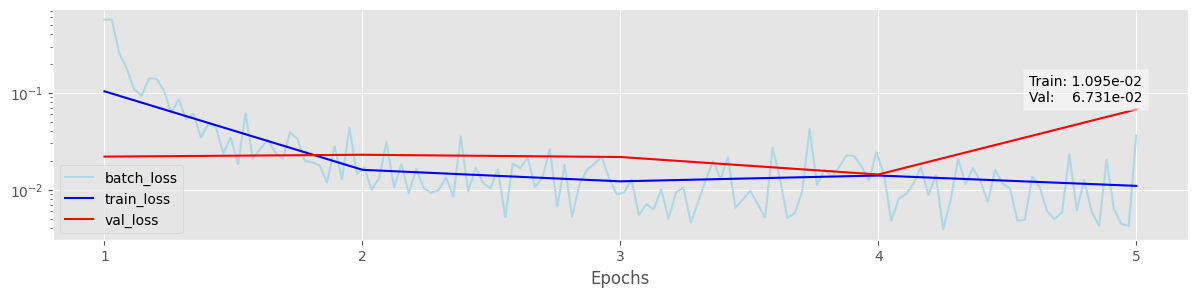

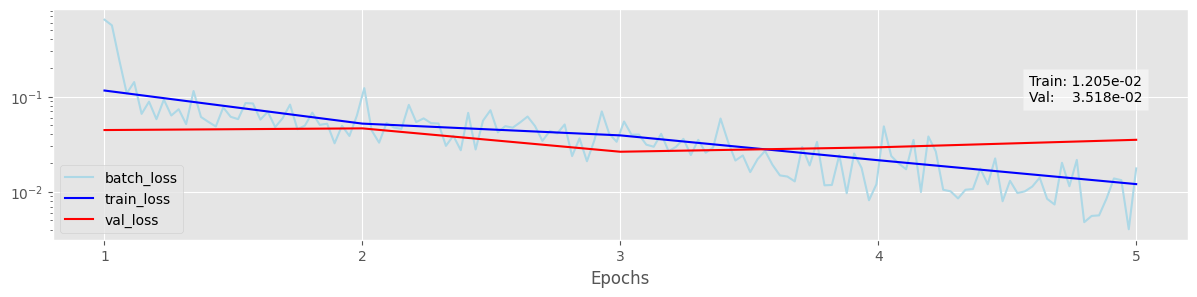

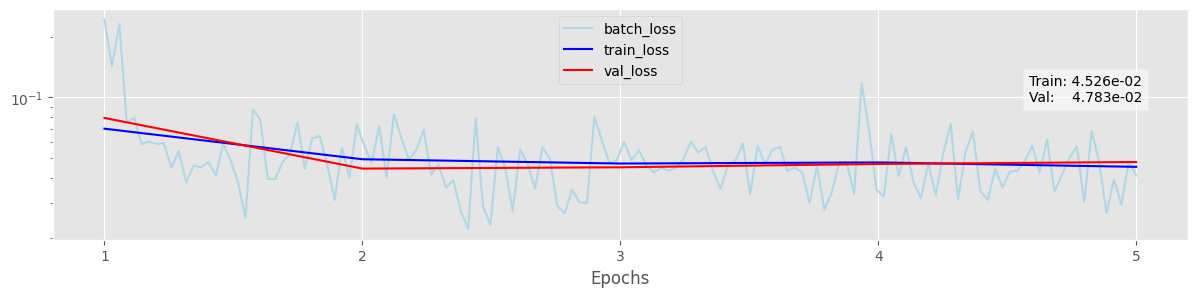

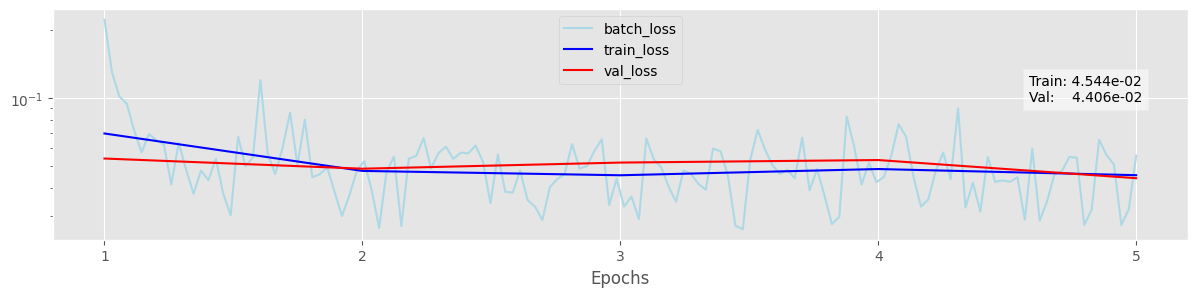

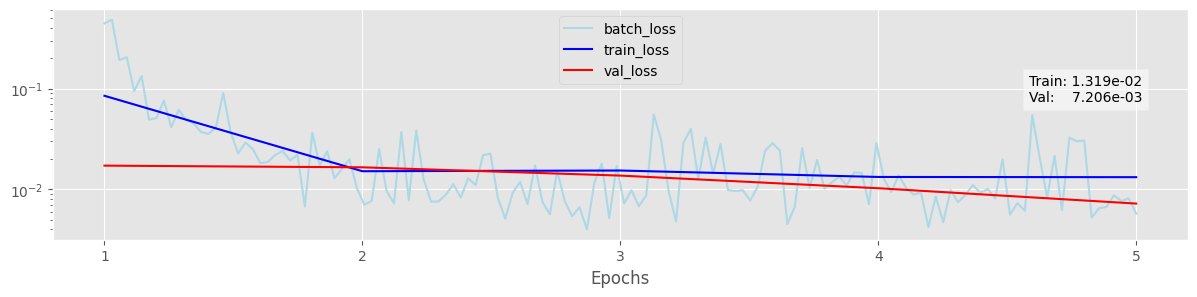

In [45]:
# OPTUNA: STUDY -------------------------------------------------------------------
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

___
SAVE CHECKPOINT

In [46]:
# SAVE MODEL -----------------------------------------------------------------
CHECKPOINT, model_destination_path = save_checkpoint(TRAINER, train_loader, val_loader, test_loader, RESULTS, CONFIG, subset_files, pth_folder)

NameError: name 'TRAINER' is not defined

___
LOAD CHECKPOINT

In [17]:
# model_destination_path = Path(pth_folder, "LSTM1_packed_old_version_241216_082030.pth")

In [ ]:
# LOAD MODEL -----------------------------------------------------------------
CHECKPOINT = load_checkpoint(model_destination_path, DEVICE)
for key in CHECKPOINT.keys(): globals()[key] = CHECKPOINT[key]
# load model and optimizer states --------------------------------------------
model.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)
model.eval()  # set model to evaluation mode for inference

___
EVALUATION

In [ ]:
# EVALUATION -----------------------------------------------------------------
# get file list of test subset
test_files = CHECKPOINT["test_files"]; print(f"{'-'*60}\nTest subset: {len(test_files)} files\n{'-'*60}")
# -------------------------------------
# evaluate model on test set
test_loss, all_outputs, all_targets, all_priors, all_original_lengths = TRAINER.evaluate_model()
# -------------------------------------
# Inverse-transform on all outputs and targets for evaluation
scaled_outputs = [target_scaler.inverse_transform(output_sequence.reshape(1, -1)).squeeze() for output_sequence in all_outputs]
scaled_targets = [target_scaler.inverse_transform(target_sequence.reshape(1, -1)).squeeze() for target_sequence in all_targets]
scaled_priors = [prior_scaler.inverse_transform(prior_sequence.reshape(1, -1)).squeeze() for prior_sequence in all_priors]

# concatenate:
all_y_true, all_y_pred, all_y_phys = np.concatenate(scaled_targets), np.concatenate(scaled_outputs), np.concatenate(scaled_priors)

# calculate evaluation metrics
print(f"Test Loss:\t\t{test_loss:.6f}")
metrics = calculate_metrics(all_y_true, all_y_pred) # [rmse, mae, std_dev, mape, r2, max_error]

___
PLOT RESULTS

In [ ]:
# get random sample sequence from test set
sample_int = random.randint(1, len(test_files)-1)
y_true, y_pred, y_phys = scaled_targets[sample_int], scaled_outputs[sample_int], scaled_priors[sample_int]

###############################################
# PLOT PREDICTION -----------------------------------------------------------------
if PLOT_ACTIVE:
     plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %'); plt.title('Battery State of Charge: Prediction vs. Actual Data') 
     plt.plot(y_true, label='Actual Data') # actual plot
     plt.plot(np.arange(0, len(y_true), 1), y_pred, label='Predicted Data') # predicted plot
     plt.plot(y_phys, label='Physical Prior') # physical prior
     plt.ylim(0, 100) # set y-axis limits

     plt.legend()
     plt.text(0.01, 0.02, f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}\nStd Dev: {np.std(y_true - y_pred):.4f}\nModel ID: {model_name_id}",\
          transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

     plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %')
     plt.plot(savgol_filter(y_true.flatten(), window_length=60, polyorder=3), label='Actual Data (Smoothed)') # actual plot
     plt.plot(np.arange(0, len(y_true), 1), savgol_filter(y_pred.flatten(), window_length=60, polyorder=3), label='Predicted Data (Smoothed)') # predicted plot
     plt.ylim(0, 100) # set y-axis limits
     plt.legend();